In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from copy import copy
from matplotlib.colors import LogNorm
#from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator

from process_functions import *

from matplotlib import style
style.use('/global/home/users/ftoralesacosta/dotfiles/scientific.mplstyle')
colors = ['#348ABD','#C70039','#FF5733','#FFC300','#65E88F','#40E0D0']

### Load Processed Data

In [2]:
#Data Unfolded From Django
cuts       = np.load('cuts.npy')
jet_pT     = np.load('jet_pT.npy')
q_perp     = np.load('q_perp.npy')
asymm_phi  = np.load('asymm_angle.npy')
weights    = np.load('weights.npy')
mc_weights = np.load("mc_weights.npy")
nn_weights = np.load("nn_weights.npy")

In [3]:
#Data Unfolded From Rapgap
cuts_h1rpgp       = np.load('from_rapgap_cuts.npy')
jet_pT_h1rpgp     = np.load('from_rapgap_jet_pT.npy')[cuts_h1rpgp]
q_perp_h1rpgp     = np.load('from_rapgap_q_perp.npy')[cuts_h1rpgp]
asymm_phi_h1rpgp  = np.load('from_rapgap_asymm_angle.npy')[cuts_h1rpgp]
weights_h1rpgp    = np.load('from_rapgap_weights.npy')[cuts_h1rpgp]
mc_weights_h1rpgp = np.load("from_rapgap_mc_weights.npy")[cuts_h1rpgp]
nn_weights_h1rpgp = np.load("from_rapgap_nn_weights.npy")[cuts_h1rpgp]

In [4]:
print(len(cuts_h1rpgp))
print(len(jet_pT_h1rpgp))
print(q_perp_h1rpgp)
print(q_perp)

54120771
8059737
[2.9258978 2.8795211 1.8521012 ... 0.9344905 2.9365401 1.597804 ]
[ 0.79072815  1.250106    1.9899492  ...  0.44995707  3.2822878
 17.964645  ]


### Load RapGap

In [5]:
rapgap_cuts      = np.load('rapgap_cuts.npy')
rapgap_jet_pT    = np.load('rapgap_jet_pT.npy')[rapgap_cuts]
rapgap_q_perp    = np.load('rapgap_q_perp.npy')[rapgap_cuts]
rapgap_asymm_phi = np.load('rapgap_asymm_angle.npy')[rapgap_cuts]
rapgap_weights   = np.load('rapgap_weights.npy')[rapgap_cuts]

In [6]:
raw_cuts = np.load("dataRaw_cuts.npy")
raw_q_perp = np.load("dataRaw_q_perp.npy")

cut_on_raw=True
if cut_on_raw:
    raw_q_perp=raw_q_perp[raw_cuts]

### Apply Cuts

In [7]:
if (len(q_perp) == len(cuts)):
    jet_pT    = jet_pT[cuts]
    q_perp    = q_perp[cuts]
    asymm_phi = asymm_phi[cuts]
    weights   = weights[cuts]
    mc_weights = mc_weights[cuts]
    nn_weights = nn_weights[cuts]
    print("%i / %i Events Remain"%(len(q_perp),len(cuts)))

else:
    print("Cuts already applied!")
    

7234481 / 57882501 Events Remain


___

## Calculate Bin Average $\cos(\phi), \cos(2\phi)$, and $\cos(3\phi)$ in Bins of $q_\perp$

### Dictionaryies and Binning

In [8]:
#Make Dictionaries and Binning
#N_Bins = 10
q_max = 10.0
q_perp_bins = np.array([ 0., 1., 2., 3., 4., 5., 6., 8., 10.])
N_Bins = len(q_perp_bins)-1
digits = np.digitize(q_perp,q_perp_bins)-1
keys=["q_perp","phi","cos1","cos2","cos3"]

In [9]:
django = {}
averages_in_qperp_bins(django, q_perp_bins, q_perp, asymm_phi,mc_weights)

Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8


In [10]:
rapgap = {}
averages_in_qperp_bins(rapgap, q_perp_bins, rapgap_q_perp, rapgap_asymm_phi,rapgap_weights)

Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8


In [11]:
#Data unfolded USING Django
h1_djgo = {}
averages_in_qperp_bins(h1_djgo, q_perp_bins, q_perp, asymm_phi,weights)

Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8


## Dictionary of Unfolded H1 Data (Main results use RAPGAP)

In [12]:
#Data unfolded USING Rapgap
h1_rpgp = {}
averages_in_qperp_bins(h1_rpgp, q_perp_bins, q_perp_h1rpgp, asymm_phi_h1rpgp,weights_h1rpgp)

Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8


# Uncertainties

In [13]:
file = open('bootstrap_errors.pkl', 'rb')
bootstrap_errors = pickle.load(file)
file.close()

In [14]:
file = open('systematics.pkl', 'rb')
systematics = pickle.load(file)
file.close()

In [15]:
stat_and_sys_error = {}
for key in keys[1:]:
    stat_and_sys_error[key] = np.sqrt((bootstrap_errors[key]*h1_rpgp[key])**2+systematics['total'][key]**2)

In [16]:
x_low =  h1_rpgp["q_perp"] - q_perp_bins[:-1]
x_high = q_perp_bins[1:] - h1_rpgp["q_perp"]
x_errors = np.array(list(zip(x_low,x_high))).T
edges=np.stack((q_perp_bins[:-1],q_perp_bins[1:])).T

___

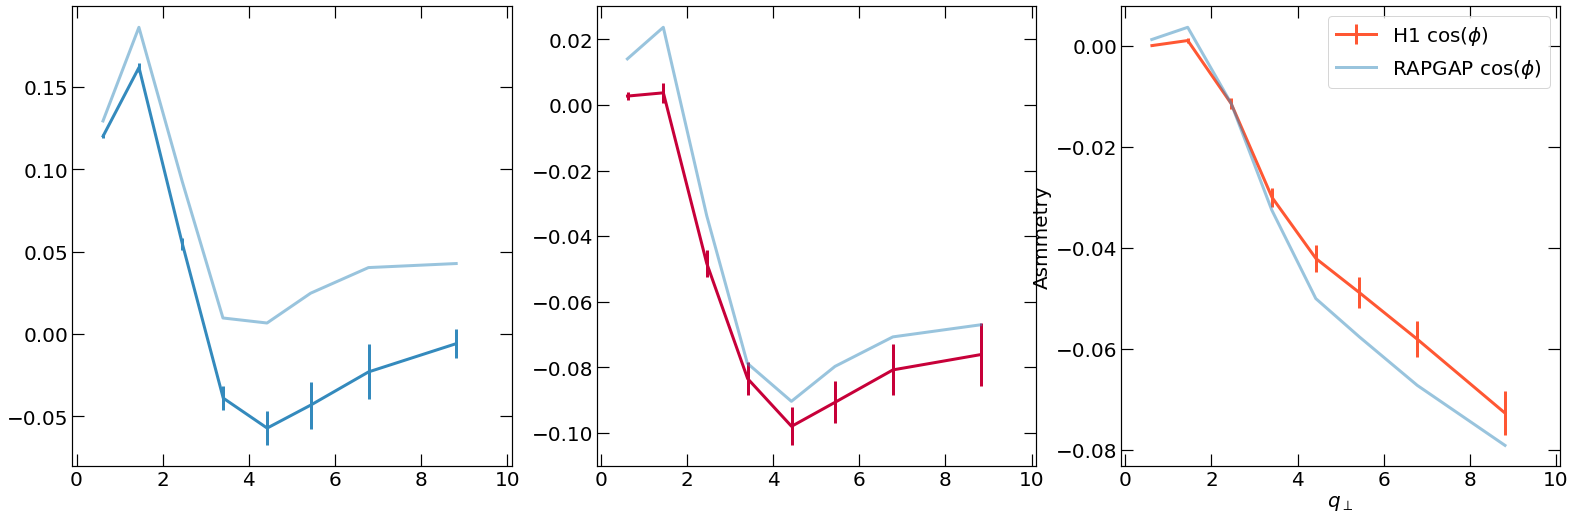

In [17]:
fig,axes = plt.subplots(1,3,figsize=(22,7))

for i,key in enumerate(["cos1","cos2","cos3"]):
    axes[i].errorbar(h1_rpgp["q_perp"],h1_rpgp[key],yerr=bootstrap_errors[key]*h1_rpgp[key],label="H1 $\cos(\phi)$",color=colors[i],linewidth=3)
    axes[i].errorbar(rapgap["q_perp"],rapgap[key],label="RAPGAP $\cos(\phi)$",alpha=0.5,linewidth=3)
    axes[i].set_xlim(-0.1,10.1)

plt.tight_layout()
plt.legend(fontsize=20)
plt.xlabel("$q_\perp$",fontsize=20)
plt.ylabel("Asmmetry",fontsize=20)
plt.savefig("unfolded_separately.pdf")

___

## Theory https://arxiv.org/pdf/2106.05307.pdf

In [18]:
theory = {}

for i in range(1,4):
    key = "cos%i"%(i)
    theory[key] = np.load("theory_cos%iphi.npy"%(i))
    theory[key] = theory[key]/i #paper plots n<cos(nphi)>
    key = key+"_x"
    theory[key] = np.load("theory_cos%iphi_x.npy"%(i))
    
    #theory, 5 points matching H1 <q_perp>, for ratios
    key = "for_ratio_cos%i"%(i)
    theory[key] = np.load("theory_for_ratio_cos%iphi.npy"%i)
    theory[key] = theory[key]/i #paper plots n<cos(nphi)>
    key = key+"_x"
    theory[key] = np.load("theory_for_ratio_cos%iphi_x.npy"%i)

## Pythia [Roli+Kyle]

In [19]:
pythia = {}

for i in range(1,4):
    key = "cos%i"%(i)
    pythia[key] = np.genfromtxt('Pythia_cos%iphi_v_qT.csv'%(i), delimiter=',')[:,1]
    key = key+"_x"
    pythia[key] = np.genfromtxt('Pythia_cos%iphi_v_qT.csv'%(i), delimiter=',')[:,0]
    
pythia_max_q_perp = 3.0
mask1 = pythia["cos1_x"] < pythia_max_q_perp
mask2 = pythia["cos2_x"] < pythia_max_q_perp
mask3 = pythia["cos3_x"] < pythia_max_q_perp

for i in range(1,4):
    key = "cos%i"%(i)+"_x"
    mask = pythia[key] < pythia_max_q_perp
    pythia[key] = pythia[key][mask]
    key = "cos%i"%(i)
    pythia[key] = pythia[key][mask]

___

## Overlay Everything

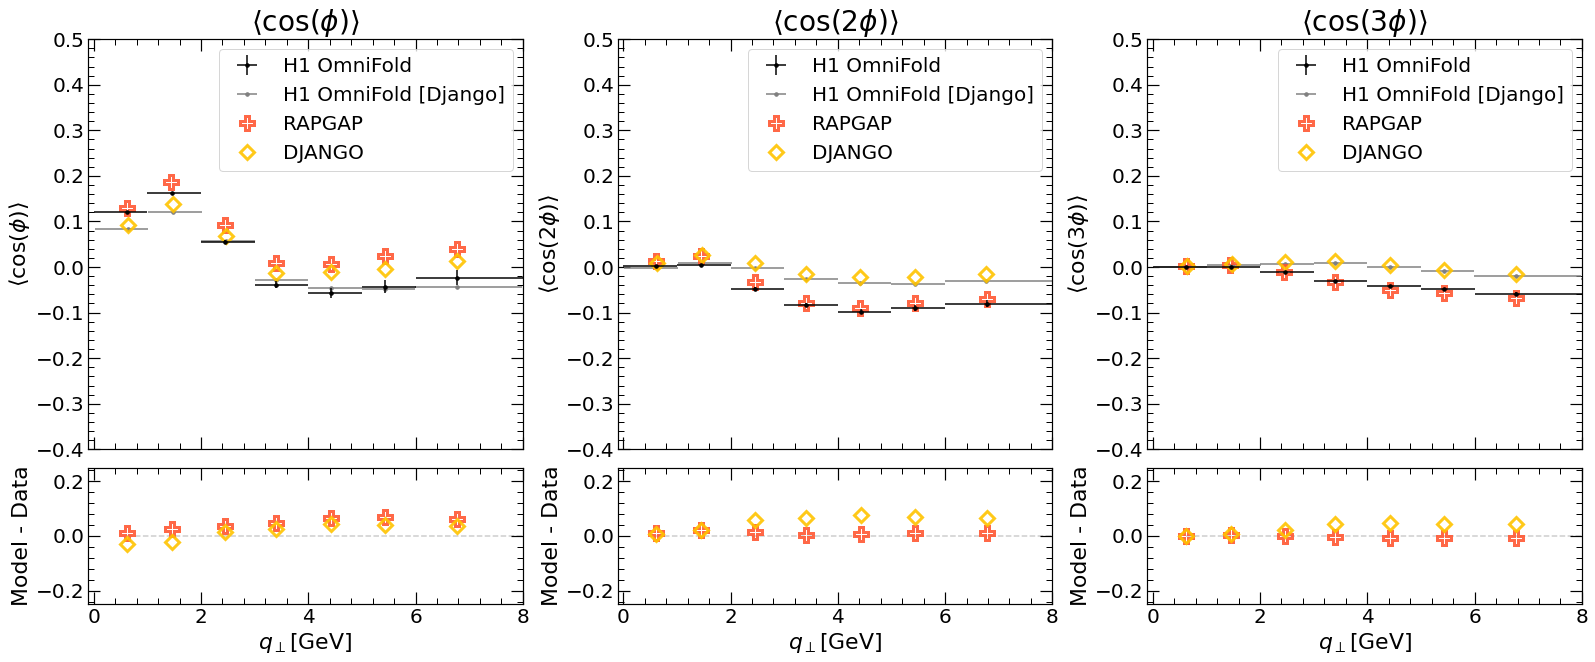

In [20]:
plot_h1rpgp = True #Default. Only one with bootstrap errors
plot_h1djgo = True

plot_rapgap = True
plot_django = True

plot_theory = False
plot_pythia = False

plot_modelSYS = False

plot_mask = np.asarray([plot_h1rpgp,plot_h1djgo,plot_rapgap,plot_django,plot_theory,plot_pythia,plot_modelSYS])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22, 9), constrained_layout=True,
                         gridspec_kw={'height_ratios': [3, 1]})
axes = np.ravel(axes)

x_max = 8.0


for i in range(3):
    
    # ----- Asymmetry Plots -----
    string = r"$\langle\cos(%i\phi)\rangle$"%(i+1)
    string = string.replace("1","")
    key = "cos%i"%(i+1)
    
    axes[i].set_title(string)
    axes[i].set_ylim(-0.4,0.5)
    axes[i].set_xlim(-0.1,x_max)
    axes[i].set_ylabel(string)
    axes[i].axes.set_xticklabels("")
    axes[i].yaxis.set_minor_locator(AutoMinorLocator(5))
    axes[i].xaxis.set_minor_locator(AutoMinorLocator(5))


    #Omnifold H1 Data
    if (plot_h1rpgp):
        axes[i].errorbar(h1_rpgp["q_perp"],h1_rpgp[key],yerr=bootstrap_errors[key]*h1_rpgp[key],xerr=x_errors,
                         label="H1 OmniFold",ls='none',ms=7,marker=".", color='black',zorder=20)
    if (plot_h1djgo):
        axes[i].errorbar(h1_djgo["q_perp"],h1_djgo[key],xerr=x_errors,
                         label="H1 OmniFold [Django]",ls='none',ms=7,marker=".",color='grey')

    #SYSTEMATICS
    if (plot_modelSYS):
        for xi in range(len(edges)):
            axes[i].fill_between(edges[xi],h1_rpgp[key][xi]-systematics['total'][key][xi],
                                 h1_rpgp[key][xi]+systematics['total'][key][xi], alpha=0.2,color='k',)
            
    #GENERATORS
    if (plot_rapgap):
        axes[i].errorbar(rapgap["q_perp"],rapgap[key],label="RAPGAP",ls='none',marker="P",
                         fillstyle='none',markeredgewidth=3,ms=14,alpha=0.9, color=colors[2])
    if (plot_django):
        axes[i].errorbar(django["q_perp"],django[key],label="DJANGO",ls='none',marker="D",
                         fillstyle='none',markeredgewidth=3,ms=10,alpha=0.9, color=colors[3])
    if (plot_pythia):
        axes[i].plot(pythia[key+"_x"],pythia[key],label="Pythia [$\cos\phi$]",
                     linewidth=4,linestyle="dashed",color=colors[1])

    #THEORY
    if (plot_theory):
        axes[i].plot(theory['for_ratio_cos%i_x'%(i+1)],theory['for_ratio_cos%i'%(i+1)],label="SGR [$\cos\phi$]",
                 ls='none',marker="s",markeredgewidth=3,ms=12,alpha=0.9, color=colors[5])
        axes[i].set_ylim(-0.6,0.6)
        
    axes[i].legend()


    # ----- RATIO PLOTS -----    
    axes[i+3].set_ylabel("Model - Data")
    axes[i+3].set_xlim(-0.1,x_max)
    axes[i+3].set_ylim(-0.25,0.25)
    axes[i+3].set_xlabel(r"$q_\perp$[GeV]")
    axes[i+3].yaxis.set_minor_locator(AutoMinorLocator(5))
    axes[i+3].xaxis.set_minor_locator(AutoMinorLocator(5))
    
    axes[i+3].errorbar(h1_rpgp["q_perp"],h1_rpgp[key] - h1_rpgp[key],ls='--',ms=7, color="black",alpha=0.2)

    if plot_modelSYS:
        model_difference = np.abs(h1_rpgp[key]-h1_djgo[key])
        for xi in range(len(edges)):
            axes[i+3].fill_between(edges[xi],-stat_and_sys_error[key][xi],stat_and_sys_error[key][xi], alpha=0.2,color='k',)
    
    if plot_rapgap:
        axes[i+3].errorbar(h1_rpgp["q_perp"],rapgap[key] - h1_rpgp[key],ls='none',marker="P",
                           fillstyle='none',markeredgewidth=3,ms=14,alpha=0.9, color=colors[2])
    
    if plot_django:
        axes[i+3].errorbar(h1_rpgp["q_perp"],django[key] - h1_rpgp[key],ls='none',marker="D",
                           fillstyle='none',markeredgewidth=3,ms=10,alpha=0.9, color=colors[3])

    if (plot_theory):
        n_theory_points = len(theory["for_ratio_cos%i"%(i+1)])
        axes[i+3].errorbar(h1_rpgp["q_perp"][:n_theory_points],theory["for_ratio_cos%i"%(i+1)] - h1_rpgp[key][:n_theory_points],
                           ls='none',marker="s",markeredgewidth=3,ms=12,alpha=0.9, color=colors[5])
        axes[i+3].set_ylim(-0.6,0.6)



strings = np.asarray(["H1_Data","Unfolded_fromDjango","Rapgap","Django","Theory","Pythia","model_SYS"])
strings = strings[plot_mask]
string = ""
for i,datum in enumerate(strings):
    string += datum
    if i > 0: string +="+"
string = string[:-1]

plt.savefig(string+".pdf")

### 2D Asymmetry Histograms

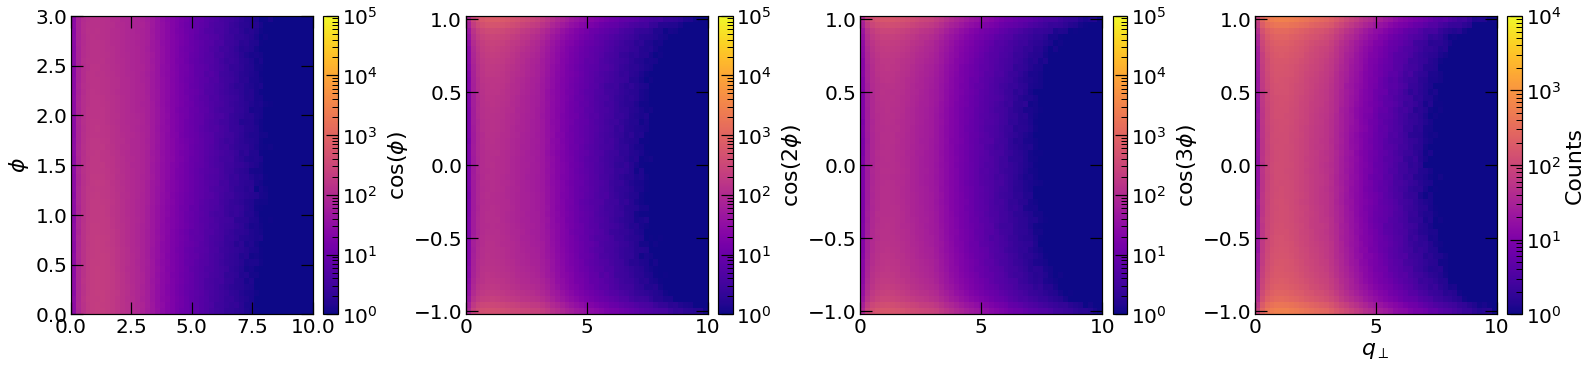

In [21]:
N_Bins = 50
xbins = np.linspace(-0.01,10.01,N_Bins)
ybins = np.linspace(-1.02,1.02,N_Bins)
cmap = copy(plt.cm.plasma)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22, 5), constrained_layout=True)


h0, xedges0, yedges0 = np.histogram2d(q_perp, (asymm_phi), bins=(np.linspace(0,10,N_Bins),np.linspace(0,3,N_Bins)), weights=weights)
h1, xedges1, yedges1 = np.histogram2d(q_perp, np.cos(asymm_phi),bins=(xbins,ybins), weights=weights)
h2, xedges2, yedges2 = np.histogram2d(q_perp, np.cos(2*asymm_phi), bins=(xbins,ybins), weights=weights)
h3, xedges3, yedges3 = np.histogram2d(q_perp, np.cos(3*asymm_phi), bins=(xbins,ybins), weights=weights)

pcm0 = axes[0].pcolormesh(xedges0, yedges0, h0.T, cmap=cmap, norm=LogNorm(vmin=1.0e0,vmax=1.0e5), rasterized=True)
pcm1 = axes[1].pcolormesh(xedges1, yedges1, h1.T, cmap=cmap, norm=LogNorm(vmin=1.0e0,vmax=1.0e5), rasterized=True)
pcm2 = axes[2].pcolormesh(xedges2, yedges2, h2.T, cmap=cmap, norm=LogNorm(vmin=1.0e0,vmax=1.0e5), rasterized=True)
pcm3 = axes[3].pcolormesh(xedges3, yedges3, h3.T, cmap=cmap, norm=LogNorm(vmin=1.0e0,vmax=1.0e4), rasterized=True)
axes[0].set_ylabel("$\phi$",fontsize=22)
axes[1].set_ylabel("$\cos(\phi)$",fontsize=22)
axes[2].set_ylabel("$\cos(2\phi)$",fontsize=22)
axes[3].set_ylabel("$\cos(3\phi)$",fontsize=22)
#cb0=axes[0].colorbar(pcm,ax)

fig.colorbar(pcm0, ax=axes[0], pad= -0.049)
fig.colorbar(pcm1, ax=axes[1], pad= -0.01)
fig.colorbar(pcm2, ax=axes[2], pad= -0.01)
cb=fig.colorbar(pcm3, ax=axes[3], pad= -0.01)

plt.xlabel("$q_\perp$",fontsize=22)
cb.set_label("Counts",fontsize=22)
plt.savefig("2D_asymmetries.png")

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 16), constrained_layout=True)
x_max = 8.0

#fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 7), constrained_layout=True)
axes = np.ravel(axes)

axes[0].errorbar(h1_rpgp["q_perp"],h1_rpgp["phi"],xerr=x_errors,
                         label="H1 OmniFold",ls='none',ms=7,marker=".", color='black')
axes[0].errorbar(h1_djgo["q_perp"],h1_djgo["phi"],xerr=x_errors,
                         label="H1 OmniFold [Django]",ls='none',ms=7,marker=".",color='grey')

axes[0].errorbar(rapgap["q_perp"],rapgap["phi"],xerr=x_errors,
                         label="H1 OmniFold",ls='none',ms=7,marker=".", color=colors[2])
axes[0].errorbar(django["q_perp"],django["phi"],xerr=x_errors,
                         label="H1 OmniFold [Django]",ls='none',ms=7,marker=".",color=colors[3])

i=0
axes[i].legend()
axes[i].set_title("H1 OmniFold Lepton-Jet Asymmetry")
#axes[i].set_xlim(-0.1,x_max)
#axes[i].set_ylim(60,165)
axes[i].set_xlabel("$q_\perp$")
axes[i].set_ylabel("$\phi$",fontsize=30)
axes[i].axes.set_xticklabels("")
axes[i].yaxis.set_minor_locator(AutoMinorLocator(5))
axes[i].xaxis.set_minor_locator(AutoMinorLocator(5))

#axes[1].hist(asymm_phi_h1rpgp*57.2958,weights=weights_h1rpgp,color=colors[2],alpha=0.5,label="Rapgap Unfolded")
#axes[1].hist(asymm_phi*57.2958,weights=weights,color=colors[3],alpha=0.5,label="Django Unfolded")
axes[1].hist(asymm_phi_h1rpgp,weights=weights_h1rpgp,color=colors[2],alpha=0.5,label="Rapgap Unfolded")
axes[1].hist(asymm_phi,weights=weights,color=colors[3],alpha=0.5,label="Django Unfolded")
axes[1].legend()
axes[1].set_xlabel("$\phi$")

axes[2].errorbar(h1_rpgp["q_perp"],h1_rpgp["sin1"],xerr=x_errors,
                         label="H1 OmniFold",ls='none',ms=7,marker=".", color='black')
axes[2].errorbar(h1_djgo["q_perp"],h1_djgo["sin1"],xerr=x_errors,
                         label="H1 OmniFold [Django]",ls='none',ms=7,marker=".",color='grey')

axes[2].errorbar(rapgap["q_perp"],rapgap["sin1"],xerr=x_errors,
                         label="H1 OmniFold",ls='none',ms=7,marker=".", color=colors[2])
axes[2].errorbar(django["q_perp"],django["sin1"],xerr=x_errors,
                         label="H1 OmniFold [Django]",ls='none',ms=7,marker=".",color=colors[3])

axes[2].set_xlim(-0.1,x_max)
axes[2].set_ylabel("$\sin(\phi)$")


axes[5].errorbar(h1_rpgp["q_perp"],h1_rpgp["cos1"],xerr=x_errors,
                         label="H1 OmniFold",ls='none',ms=7,marker=".", color='black')
axes[5].errorbar(h1_djgo["q_perp"],h1_djgo["cos1"],xerr=x_errors,
                         label="H1 OmniFold [Django]",ls='none',ms=7,marker=".",color='grey')

axes[5].errorbar(rapgap["q_perp"],rapgap["cos1"],xerr=x_errors,
                         label="H1 OmniFold",ls='none',ms=7,marker=".", color=colors[2])
axes[5].errorbar(django["q_perp"],django["cos1"],xerr=x_errors,
                         label="H1 OmniFold [Django]",ls='none',ms=7,marker=".",color=colors[3])
axes[5].set_ylabel("$\cos(\phi)$")

plt.savefig("phi.pdf")

In [23]:
np.nansum(asymm_phi_h1rpgp*weights_h1rpgp)/np.sum(weights_h1rpgp)*57.2958

82.89270889281576

In [24]:
np.arcsin(0.66)

0.7208187608700897

In [25]:
<phi>
cos<phi>
<cos(phi)>

<cos(phi)>
<cos2phi>

<cos2phi> =  <cosphi>^2 - <sinphi>^2

SyntaxError: invalid syntax (536358802.py, line 1)

In [ ]:
#plot phi foldeld/unfolded for the last q_perp bin.